In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Image Directory

In [4]:
image_dir = Path('/Users/datascientist/Downloads/food detection/Indian Food Images/Indian Food Images')

# Setting Filepath and Labels

In [5]:
# Get all jpg file paths
filepath = list(image_dir.glob('**/*.jpg'))

# Extract labels using a list comprehension
label = [os.path.split(os.path.split(path)[0])[1] for path in filepath]


# Converting it into image_df

In [6]:
# Create a dataframe directly from the lists or arrays
image_df = pd.DataFrame({
    'Filepath': filepath,
    'Label': label
})

# Shuffle the dataframe and reset the index
image_df = image_df.sample(frac=1.0, random_state=1).reset_index(drop=True)

# Display the first few rows of the dataframe
image_df.head()


,Filepath,Label
0,/Users/datascientist/Downloads/food detection/...,imarti
1,/Users/datascientist/Downloads/food detection/...,chikki
2,/Users/datascientist/Downloads/food detection/...,dal_makhani
3,/Users/datascientist/Downloads/food detection/...,sutar_feni
4,/Users/datascientist/Downloads/food detection/...,bhatura


In [7]:
len(image_df['Label'].unique())

80

In [8]:
image_df.shape

(4000, 2)

# Label encoding Food names

In [9]:
le = LabelEncoder()
image_df['Label'] = le.fit_transform(image_df['Label'])
image_df['Label'].value_counts()

Label
36    50
23    50
24    50
11    50
7     50
      ..
8     50
28    50
45    50
29    50
67    50
Name: count, Length: 80, dtype: int64

# Image Data Generator

#### Creating train_test_split

In [10]:
train_df, test_df = train_test_split(image_df, test_size = 0.30, shuffle = True, random_state = 1)

In [11]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [14]:
# Convert the 'Filepath' column to strings if not already
train_df['Filepath'] = train_df['Filepath'].astype(str)
test_df['Filepath'] = test_df['Filepath'].astype(str)


In [15]:
# Define the common parameters for the ImageDataGenerator
common_params = {
    'dataframe': train_df,
    'x_col': 'Filepath',
    'y_col': 'Label',
    'target_size': (224, 224),
    'batch_size': 32,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 42
}

# Create train and validation generators from the same training dataframe
train_image = train_gen.flow_from_dataframe(**common_params, subset='training')
val_image = train_gen.flow_from_dataframe(**common_params, subset='validation')

# Create test generator from the test dataframe
test_image = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)


Found 2240 validated image filenames belonging to 80 classes.
Found 560 validated image filenames belonging to 80 classes.
Found 1200 validated image filenames belonging to 80 classes.


# Training

In [16]:
# Define the model architecture
def create_model(input_shape=(224, 224, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Convolutional and pooling layers
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    # Global pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='linear')(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create an instance of the model
model = create_model(input_shape=(224, 224, 3), num_classes=1)

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_image,
    validation_data=val_image,
    epochs=5,
    callbacks=[early_stopping])

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 633ms/step - accuracy: 0.9875 - loss: 0.0132 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 51s 728ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 615ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 575ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123


Results

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_image, verbose=0)

# Print the results with formatted strings
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy * 100:.3f}%')


Test Loss: 0.012
Test Accuracy: 98.750%


# Plotting Training and Validation (Loss & Accuracy)

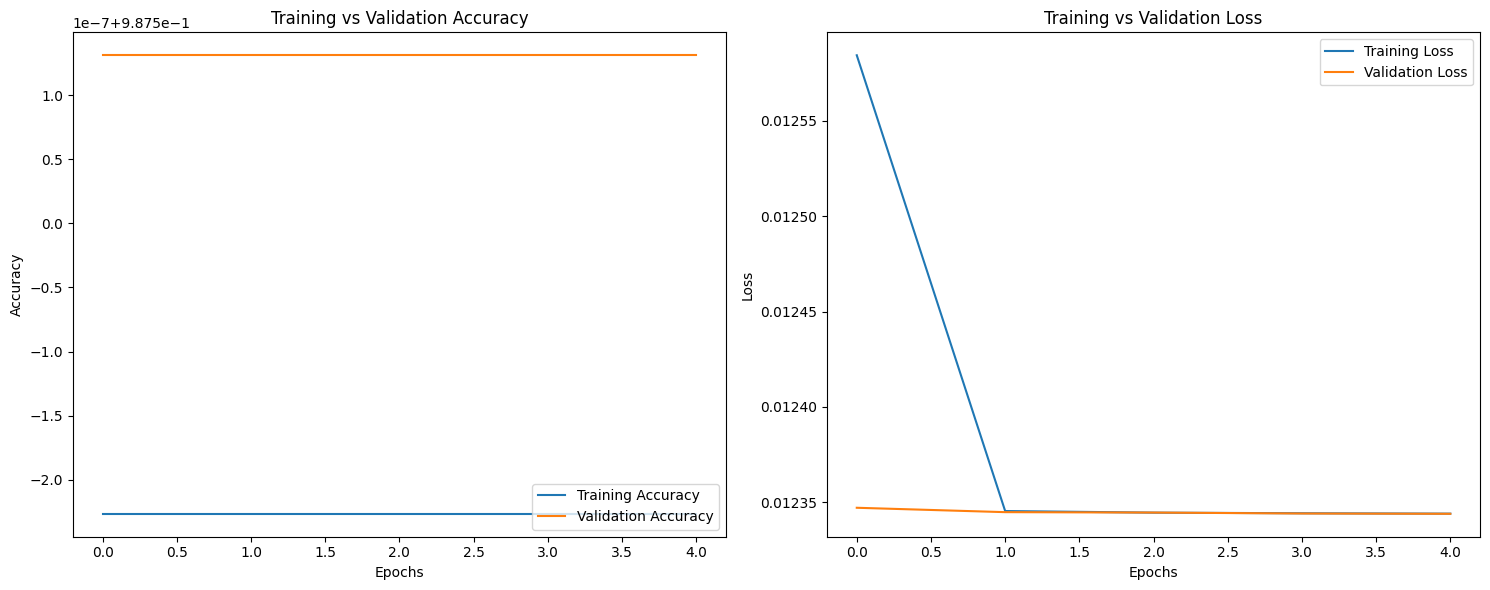

In [18]:
# Define the number of epochs for plotting
epochs = range(len(history.history['accuracy']))

# Create a figure with appropriate size
plt.figure(figsize=(15, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

#MLP MODEL

In [19]:
# Add a flattening step to the generator using a Lambda layer in the MLP model:
flatten_layer = tf.keras.layers.Flatten(input_shape=(224, 224, 3))

mlp_inputs = tf.keras.Input(shape=(224, 224, 3))
x = flatten_layer(mlp_inputs)  # Flatten the 224x224 image
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
mlp_outputs = tf.keras.layers.Dense(1, activation='linear')(x)

mlp_model = tf.keras.Model(inputs=mlp_inputs, outputs=mlp_outputs)
mlp_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,278,081 (73.54 MB)

 Trainable params: 19,278,081 (73.54 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_mlp = mlp_model.fit(train_image, validation_data=val_image, epochs=5,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.5368 - loss: 1176.3770 - val_accuracy: 0.9875 - val_loss: 0.1336
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.5194 - loss: 40.8355 - val_accuracy: 0.9300 - val_loss: 0.0802
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.5679 - loss: 18.1202 - val_accuracy: 0.0438 - val_loss: 1.8269
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.6021 - loss: 10.1396 - val_accuracy: 0.4008 - val_loss: 0.3836
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 237ms/step - accuracy: 0.6147 - loss: 5.1013 - val_accuracy: 0.8674 - val_loss: 0.1014


In [21]:
result = mlp_model.evaluate(test_image, verbose = 0)
print('Test Loss : {:.3f}'.format(result[0]))
print('Test Accuracy : {:.3f}%'.format(result[1]*100))

Test Loss : 0.079
Test Accuracy : 93.306%


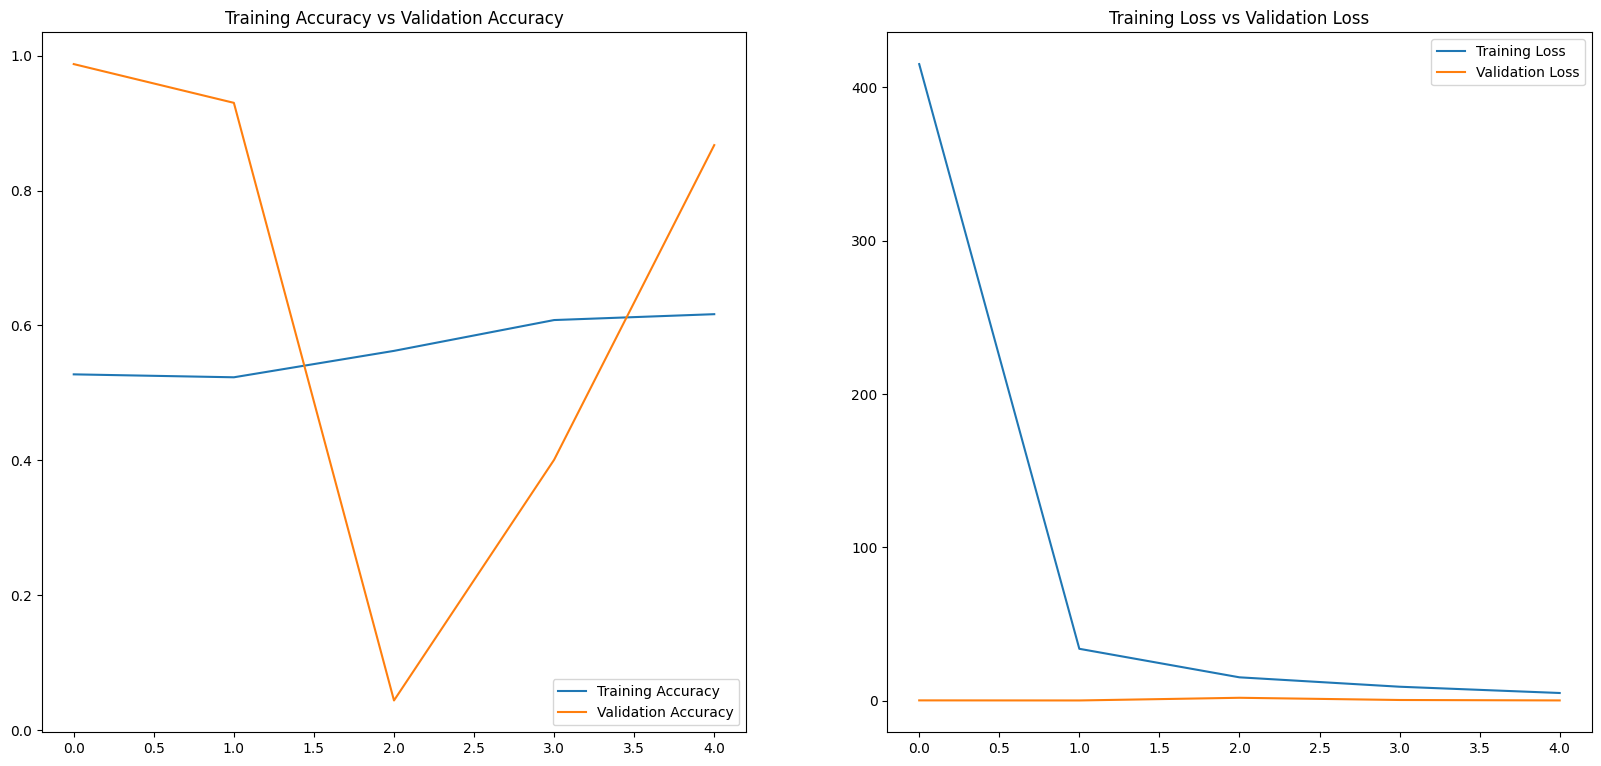

In [22]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(range(5),history_mlp.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(5), history_mlp.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend(loc = 'lower right')
plt.subplot(2,2,2)
plt.plot(range(5),history_mlp.history['loss'], label = 'Training Loss')
plt.plot(range(5), history_mlp.history['val_loss'], label = 'Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend(loc = 'upper right')
plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a feature extractor using the CNN model
feature_extractor_model = tf.keras.Model(
    inputs=mlp_model.input,
    outputs=mlp_model.layers[-3].output  # Choose the second last layer's output
)

# Extract features for training and validation data
def extract_features(generator, model):
    features = []
    labels = []
    
    for batch in generator:
        batch_images, batch_labels = batch
        batch_features = model.predict(batch_images)  # Extract features
        features.append(batch_features)
        labels.append(batch_labels)

        # Stop if generator has looped through all data
        if generator.batch_index == 0:
            break

    features = np.concatenate(features, axis=0)
    labels = np.argmax(np.concatenate(labels, axis=0), axis=1)  # Convert one-hot to integer labels
    return features, labels

# Extract features for training and testing sets
train_features, train_labels = extract_features(train_image, feature_extractor_model)
test_features, test_labels = extract_features(test_image, feature_extractor_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [24]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

# Predict and evaluate the classifier on the test set
rf_predictions = rf_classifier.predict(test_features)
rf_accuracy = accuracy_score(test_labels, rf_predictions)

print(f"Random Forest - Test Accuracy: {rf_accuracy * 100:.2f}%")


Random Forest - Test Accuracy: 14.92%


In [25]:
# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)  # You can experiment with different kernels
svm_classifier.fit(train_features, train_labels)

# Predict and evaluate the classifier on the test set
svm_predictions = svm_classifier.predict(test_features)
svm_accuracy = accuracy_score(test_labels, svm_predictions)

print(f"SVM - Test Accuracy: {svm_accuracy * 100:.2f}%")

SVM - Test Accuracy: 4.92%
